Import Libraries

In [5]:
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

Upload data file

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cleanedData.csv to cleanedData (4).csv
User uploaded file "cleanedData (4).csv" with length 133609 bytes


Read and show data file

In [7]:
data = pd.read_csv('cleanedData.csv')
data

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-12-31,1642.33,1638.43,1644.54,1632.85,161.32M,0.28%
1,2024-12-30,1637.68,1626.14,1638.56,1624.92,134.71M,0.59%
2,2024-12-27,1628.14,1617.56,1632.63,1616.69,130.61M,0.89%
3,2024-12-26,1613.70,1603.58,1615.28,1602.79,120.93M,0.67%
4,2024-12-24,1602.99,1596.64,1603.89,1596.64,95.05M,0.43%
...,...,...,...,...,...,...,...
2447,2015-01-07,1709.18,1714.70,1717.17,1706.18,171.02M,-0.43%
2448,2015-01-06,1716.58,1730.94,1730.94,1708.78,146.06M,-1.15%
2449,2015-01-05,1736.62,1758.43,1759.15,1734.51,98.14M,-0.92%
2450,2015-01-02,1752.77,1757.15,1757.96,1741.45,63.58M,-0.48%


checking and convert necessary columns

In [8]:
data.dtypes

,0
Date,object
Price,float64
Open,float64
High,float64
Low,float64
Vol.,object
Change %,object


In [9]:
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

Prepare data for LSTM training

sorting data frame

In [10]:
data = data.sort_values(by='Date')
data

,Date,Price,Open,High,Low,Vol.,Change %
2451,2014-12-31,1761.25,1759.76,1768.85,1755.93,140.84M,-0.32%
2450,2015-01-02,1752.77,1757.15,1757.96,1741.45,63.58M,-0.48%
2449,2015-01-05,1736.62,1758.43,1759.15,1734.51,98.14M,-0.92%
2448,2015-01-06,1716.58,1730.94,1730.94,1708.78,146.06M,-1.15%
2447,2015-01-07,1709.18,1714.70,1717.17,1706.18,171.02M,-0.43%
...,...,...,...,...,...,...,...
4,2024-12-24,1602.99,1596.64,1603.89,1596.64,95.05M,0.43%
3,2024-12-26,1613.70,1603.58,1615.28,1602.79,120.93M,0.67%
2,2024-12-27,1628.14,1617.56,1632.63,1616.69,130.61M,0.89%
1,2024-12-30,1637.68,1626.14,1638.56,1624.92,134.71M,0.59%


Plot the data into scatter plot to checks for outliers

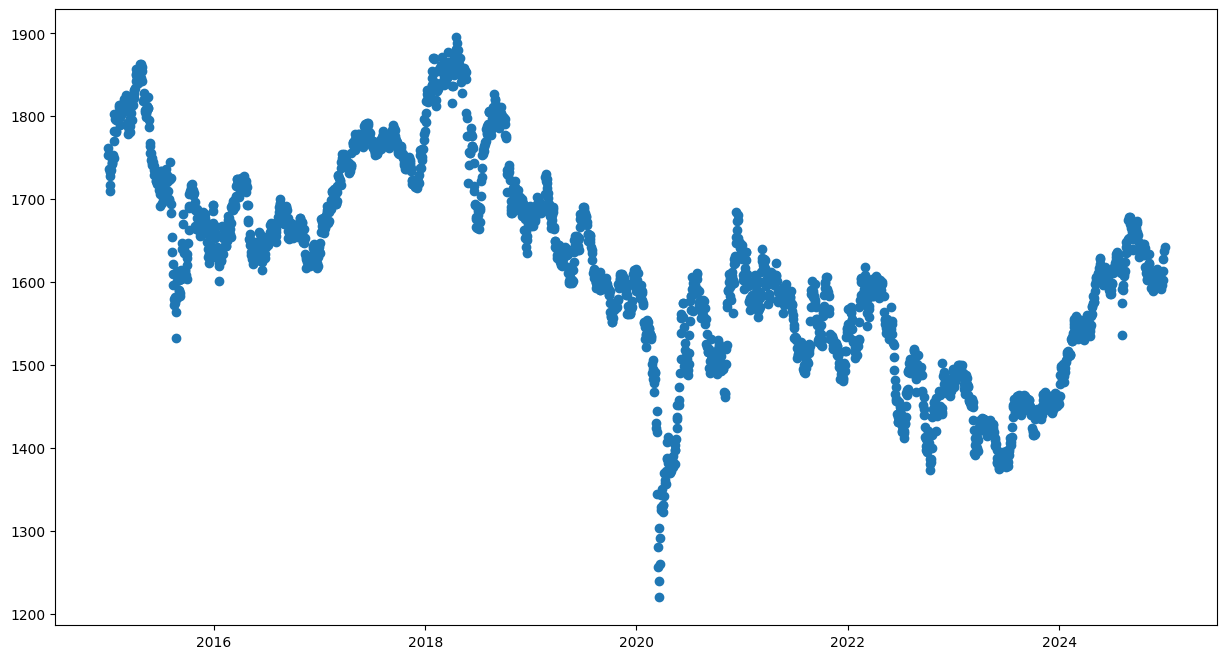

In [11]:
plt.figure(figsize=(15,8))
plt.scatter(data['Date'],data['Price'])
plt.show()

Create new columns for day, month, year, so that can be scaled

In [12]:
data['Day']=data['Date'].dt.day
data['Month']=data['Date'].dt.month
data['Year']=data['Date'].dt.year

Split data into training features and target feature

In [13]:
X = data.drop(columns=['Date','Price','Vol.','Change %'])
Y = data['Price']


Scale data using StandardScaler, the random.seed is being used here to ensure the result produced is same accross all runs

In [14]:
np.random.seed(42)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y.values.reshape(-1,1))


Creating sequence with length of 60 (60 days window), random seed also being used here to ensure result produced are same accross all runs

In [15]:
np.random.seed(42)
X_sequence, y_sequence = [],[]

for i in range(60, len(x_scaled)):
  X_sequence.append(x_scaled[i-60:i])
  y_sequence.append(Y_scaled[i,0])

X_sequence,y_sequence=np.array(X_sequence),np.array(y_sequence)

Model Architecture:

1st  LSTM layer: take in raw data and learn the basic pattern and temporal dependencies, then pass hidden states (combined thought process) to second LSTM layer.

2nd LSTM layer: take in hidden states produced by first layer of LSTM, then further learning based on processed features in the hidden states from the first LSTM layer  to capture high-level patterns and complicated relationships, then the final single hidden state will be passed to next Dense layer.

1st Dense layer: takes in the final hidden state produced by the second LSTM layer, then has its 256 units perform linear transformation on vectors of final hidden states, then apply the non-linear ‘relu’ activation. This process generates new, more abstract, and non-linear feature representations from the LSTM's output, which are then passed to the next Dense layer.

2nd Dense layer: process output from the previous layer, and then combined into single, final, condensed neuron, or the prediction.


### model - original

In [16]:

model_original = keras.models.Sequential()

model_original.add(keras.layers.LSTM(128, return_sequences=True, input_shape=(60,6)))

model_original.add(keras.layers.LSTM(128, return_sequences=False))

model_original.add(keras.layers.Dense(256,activation="relu"))

model_original.add(keras.layers.Dropout(0.5))

model_original.add(keras.layers.Dense(1))

model_original.summary()

model_original.compile(optimizer='adam',loss='mae',metrics=[keras.metrics.RootMeanSquaredError()])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,985 (914.00 KB)

 Trainable params: 233,985 (914.00 KB)

 Non-trainable params: 0 (0.00 B)

### model - adjust number of neurons

In [17]:
model_neurons_256 = keras.models.Sequential()

model_neurons_256.add(keras.layers.LSTM(256, return_sequences=True, input_shape=(60,6)))

model_neurons_256.add(keras.layers.LSTM(256, return_sequences=False))

model_neurons_256.add(keras.layers.Dense(512,activation="relu"))

model_neurons_256.add(keras.layers.Dropout(0.5))

model_neurons_256.add(keras.layers.Dense(1))

model_neurons_256.summary()

model_neurons_256.compile(optimizer='adam',loss='mae',metrics=[keras.metrics.RootMeanSquaredError()])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 256)        │       269,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 926,721 (3.54 MB)

 Trainable params: 926,721 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

### Functions - evaluation, model fitting

Evaluation function

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

def evaluation(y_true,y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)

  return mae,mse,rmse


Model training inside each split

In [23]:
import numpy as np


def model_fitting(model):
  np.random.seed(42)
  tss = TimeSeriesSplit(n_splits=5)


  mae_arr=[]
  mse_arr=[]
  rmse_arr=[]
  test_date_arr = []
  prediction_arr=[]
  Y_test_arr = []

  for i,(train_index,test_index) in enumerate (tss.split(X_sequence)):
    X_train, X_test=X_sequence[train_index],X_sequence[test_index]
    Y_train, Y_test = y_sequence[train_index],y_sequence[test_index]

    # Adjust indices to correspond to the original data DataFrame
    original_train_indices = train_index + 60
    original_test_indices = test_index + 60

    # Get the corresponding dates from the original data DataFrame
    train_start_date = data['Date'].iloc[original_train_indices[0]]
    train_end_date = data['Date'].iloc[original_train_indices[-1]]
    test_start_date = data['Date'].iloc[original_test_indices[0]]
    test_end_date = data['Date'].iloc[original_test_indices[-1]]

    #training model
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, Y_train,epochs=20,batch_size=32)

    # Predict
    prediction = model.predict(X_test)

    # prediction output in scaled form, transforming into the original form
    array_to_fix_error = np.zeros((prediction.shape[0],prediction.shape[1]))
    array_to_fix_error[:,0] = prediction[:,0]
    prediction = scaler.inverse_transform(array_to_fix_error)
    prediction = prediction[:,0]
    prediction_arr.append(prediction)


    # transform scaled Y_test into original form, for prediction result comparison
    Y_test_reshaped = Y_test.reshape(-1, 1)
    original_Y_test = scaler.inverse_transform(Y_test_reshaped)
    Y_test_arr.append(original_Y_test)


    mae,mse,rmse = evaluation(original_Y_test,prediction)
    mae_arr.append(mae)
    mse_arr.append(mse)
    rmse_arr.append(rmse)

    test_dates = data['Date'].iloc[original_test_indices]
    test_date_arr.append(test_dates)



    print(f"Split {i}")
    # Print the start and end dates using the extracted date information
    print(f"Train: {train_start_date.strftime('%Y-%m-%d')} to {train_end_date.strftime('%Y-%m-%d')}")
    print(f"Test:  {test_start_date.strftime('%Y-%m-%d')} to {test_end_date.strftime('%Y-%m-%d')}")

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")

  print(f"Average MAE: {np.mean(mae_arr):.2f}")
  print(f"Average MSE: {np.mean(mse_arr):.2f}")
  print(f"Average RMSE: {np.mean(rmse_arr):.2f}")


  # # Plotting result of every split
  # for i in range(len(prediction_arr)):
  #   plt.figure(figsize=(12,8))
  #   plt.plot(test_date_arr[i], Y_test_arr[i], color='red', label='Actual Test Price')
  #   plt.plot(test_date_arr[i], prediction_arr[i], color='blue', label='Predicted Price')
  #   plt.title(f'Close Price Prediction vs Actual (split{i})')
  #   plt.xlabel('Date')
  #   plt.ylabel('Close Price')
  #   plt.legend()
  #   plt.xticks(rotation=45)
  #   plt.tight_layout()
  #   plt.show()

In [24]:
np.random.seed(42)
model_fitting(model_original)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.3962 - root_mean_squared_error: 0.5501
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.2224 - root_mean_squared_error: 0.2889
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.1782 - root_mean_squared_error: 0.2319
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.1618 - root_mean_squared_error: 0.2184
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.1507 - root_mean_squared_error: 0.2039
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 0.1519 - root_mean_squared_error: 0.2035
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.1433 - root_mean_squared_error: 0.1891
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss: 0.1358 - root_mean_squared_error: 0.1826
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.1387 - root_mean_squared_error: 0.1862
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - loss: 0.1690 - root_mean_squared_err

In [25]:
np.random.seed(2)
model_fitting(model_neurons_256)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step - loss: 0.3662 - root_mean_squared_error: 0.4884
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 381ms/step - loss: 0.1774 - root_mean_squared_error: 0.2366
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step - loss: 0.1604 - root_mean_squared_error: 0.2117
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 429ms/step - loss: 0.1538 - root_mean_squared_error: 0.1999
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - loss: 0.1421 - root_mean_squared_error: 0.1849
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - loss: 0.1474 - root_mean_squared_error: 0.1937
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - loss: 0.1461 - root_mean_squared_error: 0.1923
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step - loss: 0.1424 - root_mean_squared_error: 0.1992
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 496ms/step - loss: 0.1311 - root_mean_squared_error: 0.1710
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - loss: 0.1492 - root_mean_square